<center><h1>DATA Science Project - 2 (Group_17)<h1>

<center><h1><span style = "color: red;"> Feature Extraction form Image<h1>
<h4><span style = "color: blue;">Monofractal, Multifractal, Gray level co-occurence Matrix<h4> 


## Import Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import cv2
from skimage.feature import canny
from skimage.filters.rank import equalize
from skimage.morphology import disk
from skimage.feature import greycomatrix, greycoprops
from skimage import data
from PIL import Image
from numpy import asarray




### Loading and Visualizing an Image

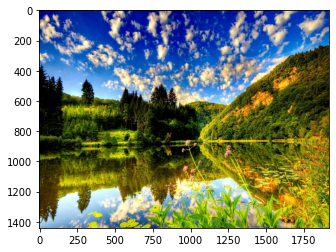

In [2]:
img = mpimg.imread('sky.jpg')
plt.imshow(img)

### Analyzing image

In [3]:
img.shape

(1440, 1920, 3)

In [4]:
img.size

8294400

## (1) Image Input and preprocessing

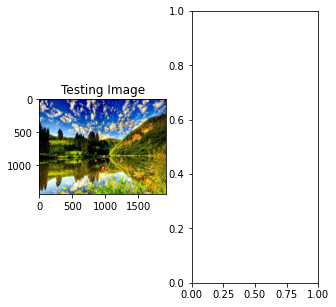

In [5]:
image = cv2.imread('sky.jpg')
test_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# segment--- gray scale
test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

fx, plots = plt.subplots(1,2, figsize=(5,5))

plots[0].set_title("Testing Image")
plots[0].imshow(test_image)


## (2) Gray & Binary Image Conversion

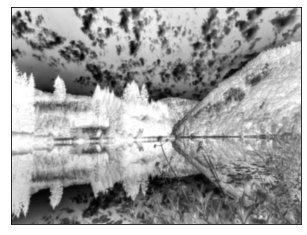

In [6]:
img = cv2.imread('sky.jpg',0)
plt.imshow(img, cmap = 'binary', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

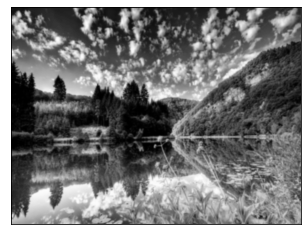

In [7]:

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

### (2.1)Feature Extraction of Image

In [8]:
pixel_feat1 = np.reshape(img, (1440*1920))
pixel_feat1

array([ 16,  16,  17, ..., 160, 147, 101], dtype=uint8)

### (2.2) Histogram


Text(0.5, 1.0, 'histogram of binary values')

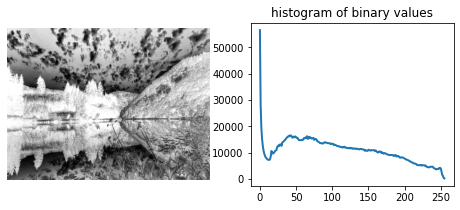

In [9]:
from skimage.exposure import histogram
hist, hist_centers = histogram(img)

#Plotting the Image and the Histogram of binary values
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.binary)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of binary values')

Text(0.5, 1.0, 'histogram of gray values')

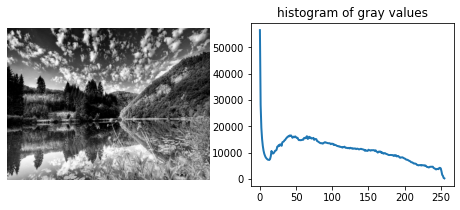

In [10]:
hist, hist_centers = histogram(img)

#Plotting the Image and the Histogram of gray values
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[0].axis('off')
axes[1].plot(hist_centers, hist, lw=2)
axes[1].set_title('histogram of gray values')

# 1. Gray level co-occurence Matrix

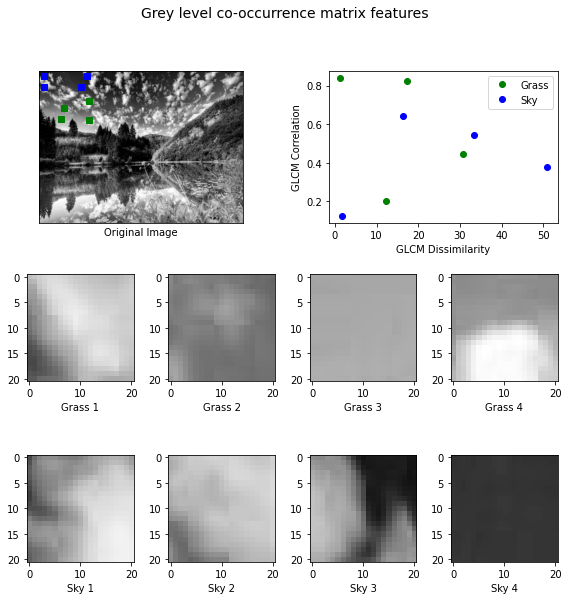

In [11]:


PATCH_SIZE = 21

# loding image

#image =cv2.imread('grl.png',0)
image = cv2.imread('sky.jpg',0)

# select some patches from grassy areas of the image
grass_locations = [(280, 454), (342, 223), (444, 192), (455, 455)]
grass_patches = []
for loc in grass_locations:
    grass_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from sky areas of the image
sky_locations = [(38, 34), (139, 28), (37, 437), (145, 379)]
sky_patches = []
for loc in sky_locations:
    sky_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
for patch in (grass_patches + sky_patches):
    glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in grass_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in sky_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(grass_patches)], ys[:len(grass_patches)], 'go',
        label='Grass')
ax.plot(xs[len(grass_patches):], ys[len(grass_patches):], 'bo',
        label='Sky')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(grass_patches):
    ax = fig.add_subplot(3, len(grass_patches), len(grass_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Grass %d' % (i + 1))

for i, patch in enumerate(sky_patches):
    ax = fig.add_subplot(3, len(sky_patches), len(sky_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('Sky %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# 2. Monofractal

## 2.1 Calculating Fractal Dimension

(800, 1200, 3)

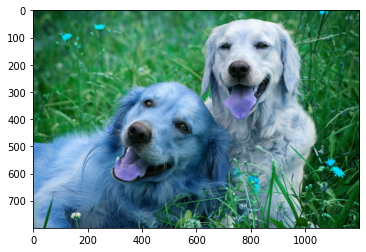

In [12]:
img = cv2.imread('dog.jpg')
plt.imshow(img)
img.shape

In [13]:

def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 20, n_offsets = 0, plot = False):
   
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
    scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
    #get the locations of all non-zero pixels
    locs = np.where(array > 0)
    voxels = np.array([(x,y) for x,y in zip(*locs)])
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    
    
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)
    
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log(1/scales), np.log(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel("$\log N(\epsilon)$")
        ax.set_xlabel("$\log 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log(1/scales))
        ax.plot(np.log(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],2)}X+{coeffs[1]}")
        ax.legend();
    return(coeffs[0])
    




Fractal Dimension of the box: 1.9186097339959973


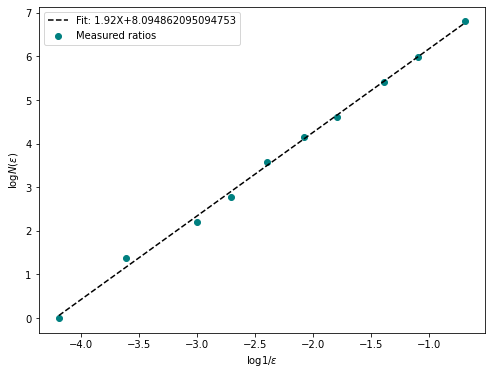

In [14]:

box = np.zeros(shape = (800, 1200))
box[20:80,20:80] = 1

fd = fractal_dimension(box, n_offsets=10, plot = True)
print(f"Fractal Dimension of the box: {fd}")
plt.show()

## 2.2 Calculating Lacunarity

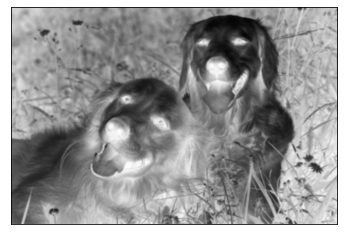

In [15]:

img=cv2.imread('dog.jpg',0)
plt.imshow(img,cmap='binary',interpolation='bicubic')
plt.xticks([]),plt.yticks([])
plt.show()

In [16]:
img_array=np.array(img) # store image in the array

In [17]:
# image Array
img_array 


array([[ 57,  54,  50, ...,  47,  47,  47],
       [ 56,  53,  50, ...,  47,  47,  47],
       [ 54,  52,  49, ...,  48,  47,  47],
       ...,
       [156, 156, 156, ...,  47,  39,  35],
       [148, 152, 156, ...,  32,  38,  43],
       [151, 149, 147, ...,  34,  35,  32]], dtype=uint8)

In [18]:
# shape of image
img_array.shape

(800, 1200)

In [19]:
# Find the mean of image which is stored in the array
mean=img_array.mean()
mean

117.46998958333333

In [20]:
# Find the standard deviation of image which is stored in the array
std=img_array.std()
std

52.59981589994613

#### Lacunarity Formula

In [21]:

lacunarity=(mean*mean/std*std)

In [22]:
lacunarity

13799.198452708439

# 3. Multifractal

uint8
(800, 1200, 3)


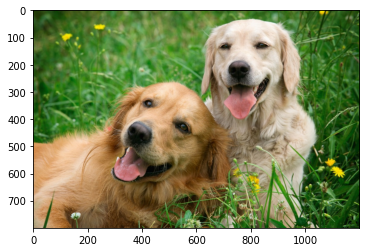

In [23]:
image =mpimg.imread('dog.jpg')
print(image.dtype)
print(image.shape)
plt.imshow(image)
plt.show()

In [24]:
image=Image.open('dog.jpg')
data=asarray(image)
print(type(data))
print(data.shape)


<class 'numpy.ndarray'>
(800, 1200, 3)


In [25]:
print(data)

[[[ 43  72  14]
  [ 40  69  11]
  [ 35  66   9]
  ...
  [ 22  67  10]
  [ 20  67  12]
  [ 20  67  12]]

 [[ 42  71  13]
  [ 39  68  10]
  [ 35  66   9]
  ...
  [ 22  67  10]
  [ 20  67  12]
  [ 20  67  12]]

 [[ 40  69  13]
  [ 38  67  11]
  [ 35  64   8]
  ...
  [ 21  68  13]
  [ 20  67  13]
  [ 20  67  13]]

 ...

 [[177 152 121]
  [177 153 119]
  [177 152 121]
  ...
  [ 26  63  20]
  [ 19  54  14]
  [ 15  50  10]]

 [[170 144 111]
  [174 148 113]
  [178 152 119]
  ...
  [  8  49   5]
  [ 16  54  13]
  [ 22  59  18]]

 [[173 147 112]
  [171 145 110]
  [169 143 108]
  ...
  [  9  52   7]
  [ 13  51  10]
  [ 10  48   7]]]


In [26]:
sum_row=data.sum(axis=1)
print(sum_row)
sum_row.shape

[[ 78858 126625  40853]
 [ 79650 127394  41389]
 [ 80501 128132  41902]
 ...
 [102600 110426  54160]
 [102817 110532  54053]
 [102749 110331  53890]]


(800, 3)

In [27]:
sum_col=data.sum(axis=0)
print(su_col)
sum_col.shape

NameError: name 'su_col' is not defined